## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [7]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
#pip install emoji

# ooh do we need to do this? -P 

In [9]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [10]:
# sample 1000 rows for writing code
congress_tweets = congress_tweets.sample(n = 1000, random_state = 10)

In [11]:
congress_tweets['text']

36257     Before adopting Olivia, we spent a great amoun...
548996    Are we supposed to take Trump seriously or lit...
652347    Thank you to Lieutenant Mike Tarr and Fire Chi...
267614    Made remarks to @AmFreeSyria sharing my concer...
344386    @jeroneanderson @MontcoLP @LelandShow @realDon...
                                ...                        
745540    Thank you @honorair for organizing these meani...
832336    RT @HouseGOP 🚨 NEW: @China_TaskForce releases ...
53451     The President has worked dilligenty since his ...
758647    RT @BobMooreNews "It's not OK to say that all ...
201571    As a combat veteran and member of the @Nationa...
Name: text, Length: 1000, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

First, we create two dictionaries to add to the default stop words -- one that has a bunch of html gunk, and another that has popular Twitter abbreviations.

In [12]:
gunk = {'\n',
 '\n\n',
 '\n\n\n',
 '\n\n\n\n',
 '\n\n ',
 '\n\n\xa0 ',
 '\n ',
 '\n \n',
 '\n \n ',
 '\n  ',
 '\n   ',
 '\n\xa0\n',
 ' ',
 ' \n',
 ' \n\n',
 ' \n ',
 '  ',
 '  \n\n ',
 '   ',
 '     ',
 '"',
 "'",
 '-PRON-','’	','—','’'} # there's probably a more elegant way to do this than what I did

twitter_abbreviations = {'mt','rt','dm','prt','ht','cc'} 
# lifted from https://www.businessinsider.com/twitter-acronyms-2012-4

In [13]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    # adds twitter abbreviations to stop words
    nlp.Defaults.stop_words |= twitter_abbreviations
    
    nlp.Defaults.stop_words |= gunk
    
    # removes punctuation and digits, converts to lowercase
    punc_free = "".join([ch for ch in text if ch not in punc if not ch.isdigit()]).lower()
    
    # we could remove emojis, but they don't seem to trip up spaCy. Still need to get this to work
    # punc_emoji_free = give_emoji_free_text(punc_free)
    
    doc = nlp(punc_free)
    
    # lemmatizes rather than just tokenizing
    spacy_words = [token.lemma_ for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    # my more elegant way of removing the new lines lies broken here
    #spacy_words = [ x for x in spacy_words if '\n' in x ]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [14]:
congress_tweets['tokens'] = [rem_punc_stop(x) for x in congress_tweets['text']]
congress_tweets['tokens'] # note -- -PRON- refers to pronoun, the lemmatizer does this

36257     [adopt, olivia, spend, great, time, learn, ari...
548996    [suppose, trump, seriously, literally, steel, ...
652347    [thank, lieutenant, mike, tarr, fire, chief, o...
267614    [remark, amfreesyria, share, concern, devastat...
344386    [jeroneanderson, montcolp, lelandshow, realdon...
                                ...                        
745540    [thank, honorair, organize, meaningful, trip, ...
832336    [housegop, 🚨, new, chinataskforce, release, ch...
53451     [president, work, dilligenty, election, find, ...
758647    [bobmoorenews, ok, federal, employee, support,...
201571    [combat, veteran, member, nationalguard, grate...
Name: tokens, Length: 1000, dtype: object

In [15]:
# peek at the tokens
#tokens_reduced = []
#tokens_reduced = [tokens_reduced.append(word) for word in congress_tweets['tokens']]

Now that we've obtained the lemmas for each tweet, we'll want to count them for text featurization. One way to do this is via the bag-of-words approach. We'll use the function that we built to remove the stop words and punctuation, and lemmatize, to initialize our CountVectorizer.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
bow_vector = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(1,1))
bow_matrix = bow_vector.fit_transform(congress_tweets['text'])
bow_matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [17]:
feature_names = bow_vector.get_feature_names()
feature_names[0:50] # peek at our features

['aacuna',
 'aal',
 'aapi',
 'aapmhq',
 'abandon',
 'abc',
 'abcnewslive',
 'abdicate',
 'abierta',
 'ability',
 'able',
 'abolish',
 'abortion',
 'abqschools',
 'abroad',
 'abrupt',
 'absentee',
 'absolutely',
 'abt',
 'abundance',
 'abuse',
 'aca',
 'academy',
 'acarrillonews',
 'accept',
 'acceptable',
 'access',
 'accident',
 'accommodation',
 'accompany',
 'accomplished',
 'accomplishment',
 'accord',
 'account',
 'accountability',
 'accountable',
 'accurate',
 'acelerar',
 'acfhhs',
 'achieve',
 'achievement',
 'acknowledge',
 'acostaresign',
 'acquaintance',
 'acquire',
 'acquit',
 'acquittal',
 'acre',
 'act',
 'action']

Great, these feature names seem fairly reasonable. However, the tf-idf matrix is an extension of the bag-of-words approach that should be more helpful to us, because it removes very common words that don't add much to the analysis.

In [18]:
tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop)
matrix = tfidf_vector.fit_transform(congress_tweets['text'])
matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
feature_names = tfidf_vector.get_feature_names()

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: A look at the top n-grams

We'll want to visualize the most commonly-used words and phrases in our dataset. First, we'll try unigrams.

In [20]:
# initialize the BOW countervectorizer with ngram_range argument
countvec = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(1,1))
ngrams = countvec.fit_transform(congress_tweets['text'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

In [21]:
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head() # take a peek

# interesting. What the heck is 'amp'? Am I just old...?
# hmm, could it be ampersand? -P
# that's a good guess Paul, I have no idea what amp is. I, too, am old lol -JS

,ngrams,freq
0,amp,261
1,today,172
2,qt,150
3,work,101
4,need,100


Okay, but pretty devoid of context. Let's calculate and visualize the top 25 bigrams.

In [22]:
# initialize the BOW countervectorizer with ngram_range argument up to 2
countvec = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(2,2))
ngrams = countvec.fit_transform(congress_tweets['text'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)

/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


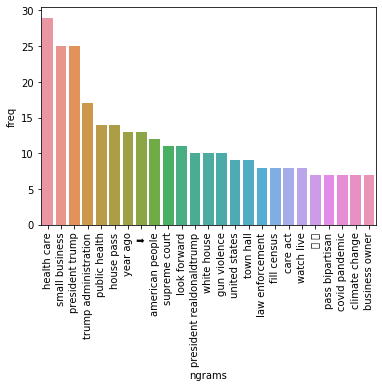

In [23]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

The bigrams seem pretty intelligible indeed. Healthcare was tweeted about the most, with President Trump as a close second. Small business comes in third. It will be interesting to understand the extent to which themes of health versus economy sort themselves along party lines. Likewise, it will be interesting to understand the sentiment of the tweets mentioning Trump, and the extent to which it falls along party lines or legislative chambers. For example, if we hypothesize that the Senate is the "cooling saucer" of Congress, perhaps senators' tweets refrain from critiquing Trump.

### EDA 2: A first pass at LDA

How do these tokens combine to compose topics in the 116th Congressional tweets? Let's use LDA to take an initial look. First, we'll create our tf-idf matrix.

In [24]:
X = congress_tweets['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

We'll fit the LDA model, arbitrarily starting with five topics.

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=6, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [26]:
lda.n_components

6

We'll get the top tokens for each of our five topics, and print them along with our feature names.

In [27]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [28]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 30)


Topic #0:
vote amp bill help today family need community people act join house democrats covid pass work visit stop health impeachment trump read good town president qt care protect hall ✅

Topic #1:
amp covid work need protect trump support qt congress today people vaccine act health election join american president continue new business time know state million stay provide federal family americans

Topic #2:
amp year today trump act president thank support country join equality continue community qt day pass health great covid right pay business win american people work program time ago house

Topic #3:
today health amp thank realdonaldtrump act country americans president violence house community economic care school congress need gun join time vote hr way right new bill energy year week pandemic

Topic #4:
amp today help work qt nation fight need day ensure veteran want new time election country state vote president care report health coronavirus american thank crisis member join 

The topics don't seem super well-separated or coherent, so we may have to play around with the number of components. For example, 4 out of 5 of the topics contain "covid" or coronavirus. This might not be totally worrisome, except that they don't appear to be very distinct in other respects -- most mention work and voting, as well as Congress and the president. Topic 3 appears the most distinact, perhaps a bit antagonistic to Trump or impeachment-related -- it is the only one that does not mention the president or health, but "impeachment" as well as words like "crisis," "fight," "act," "people," and "protect."

Checking the topic distributions for separation across our categories of interest: party and Congress vs. Senate. 

In [29]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.02753335, 0.02735102, 0.0274003 , 0.02735734, 0.86281435,
        0.02754364],
       [0.04052227, 0.04055181, 0.04051453, 0.04055092, 0.04055213,
        0.79730834],
       [0.0406705 , 0.0406803 , 0.79588667, 0.04097819, 0.04076347,
        0.04102086],
       ...,
       [0.02713596, 0.02721102, 0.02716824, 0.0271341 , 0.02729987,
        0.86405081],
       [0.03159515, 0.84205852, 0.03155368, 0.03156055, 0.03157337,
        0.03165873],
       [0.02716335, 0.02727704, 0.02708642, 0.02739459, 0.86409352,
        0.02698507]])

In [30]:
topic_dist_df = pd.DataFrame(topic_dist, columns = ["Topic " + str(x) for x in range(0, lda.n_components)])
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,index,tweet_id,screen_name,datetime,...,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,0.027533,0.027351,0.027400,0.027357,0.862814,0.027544,36257,1.276160e+18,RepDavid,2020-06-25T10:22:13-04:00,...,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[adopt, olivia, spend, great, time, learn, ari..."
1,0.040522,0.040552,0.040515,0.040551,0.040552,0.797308,548996,1.082280e+18,RepSeanMaloney,2019-01-07T09:33:39-05:00,...,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[suppose, trump, seriously, literally, steel, ..."
2,0.040671,0.040680,0.795887,0.040978,0.040763,0.041021,652347,1.322270e+18,RepSteveChabot,2020-10-30T16:24:14-04:00,...,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[thank, lieutenant, mike, tarr, fire, chief, o..."
3,0.029056,0.029134,0.029082,0.854666,0.029040,0.029022,267614,1.103730e+18,SenatorRisch,2019-03-07T13:33:23-05:00,...,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[remark, amfreesyria, share, concern, devastat..."
4,0.046526,0.046491,0.046515,0.767418,0.046525,0.046525,344386,1.097350e+18,RepThomasMassie,2019-02-17T23:35:06-05:00,...,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, montcolp, lelandshow, realdon..."


In [31]:
grouped = df_w_topics.groupby('party')
for i in df_w_topics.columns[0:lda.n_components]:
    print(grouped[i].mean().sort_values(ascending=False))

party
Independent    0.338733
Democrat       0.172775
Republican     0.159073
Name: Topic 0, dtype: float64
party
Democrat       0.189232
Republican     0.139204
Independent    0.033639
Name: Topic 1, dtype: float64
party
Democrat       0.186892
Republican     0.144737
Independent    0.033856
Name: Topic 2, dtype: float64
party
Independent    0.230141
Republican     0.187337
Democrat       0.152872
Name: Topic 3, dtype: float64
party
Independent    0.226387
Republican     0.187767
Democrat       0.135567
Name: Topic 4, dtype: float64
party
Republican     0.181881
Democrat       0.162663
Independent    0.137245
Name: Topic 5, dtype: float64


In [32]:
grouped = df_w_topics.groupby('position')
for i in df_w_topics.columns[0:lda.n_components]:
    print(grouped[i].mean().sort_values(ascending=False))
    

position
Rep    0.169482
Sen    0.167888
Name: Topic 0, dtype: float64
position
Rep    0.176755
Sen    0.148909
Name: Topic 1, dtype: float64
position
Rep    0.175384
Sen    0.155122
Name: Topic 2, dtype: float64
position
Sen    0.166724
Rep    0.165937
Name: Topic 3, dtype: float64
position
Sen    0.162143
Rep    0.153149
Name: Topic 4, dtype: float64
position
Sen    0.199214
Rep    0.159293
Name: Topic 5, dtype: float64


## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [33]:
#checking dataset
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
36257,1.276160e+18,RepDavid,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654",adopt olivia spend great time learn arizona fo...
548996,1.082280e+18,RepSeanMaloney,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",suppose trump seriously literally steel barrie...
652347,1.322270e+18,RepSteveChabot,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",thank lieutenant mike tarr fire chief ott hube...
267614,1.103730e+18,SenatorRisch,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911",remark amfreesyria share concern devastation w...
344386,1.097350e+18,RepThomasMassie,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190",jeroneanderson montcolp lelandshow realdonaldt...


In [34]:
#Conservative rep - Bradley Byrne
byrne_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Bradley Byrne']
byrne_tweets['polarity'] = byrne_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
byrne_tweets['subjectivity'] = byrne_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#Liberal rep - Maxine Waters
waters_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Maxine Waters']
waters_tweets['polarity'] = waters_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
waters_tweets['subjectivity'] = waters_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#Combine data frames
tweets_combined = [byrne_tweets, waters_tweets]
sentiment_1 = pd.concat(tweets_combined)

/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is t

In [35]:
#Trying .loc for conservative rep - Bradley Byrne - NONE OF THIS WORKS
#byrne_tweets = congress_tweets.loc[:,('name_wikipedia')] = 'Bradley Byrne'
#byrne_tweets = congress_tweets.loc[:,('name_wikipedia')] = Bradley Byrne
#byrne_tweets = congress_tweets.loc[:,('name_wikipedia')]
#byrne_tweets.head()

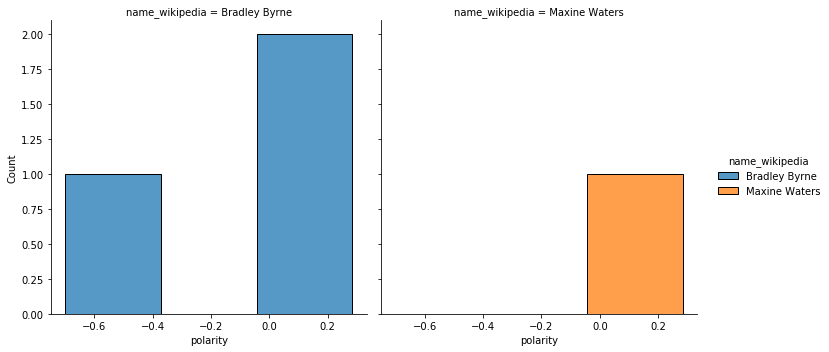

In [36]:
#Plot sentiment polarity for conservative & liberal legislators
sns.displot(sentiment_1, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

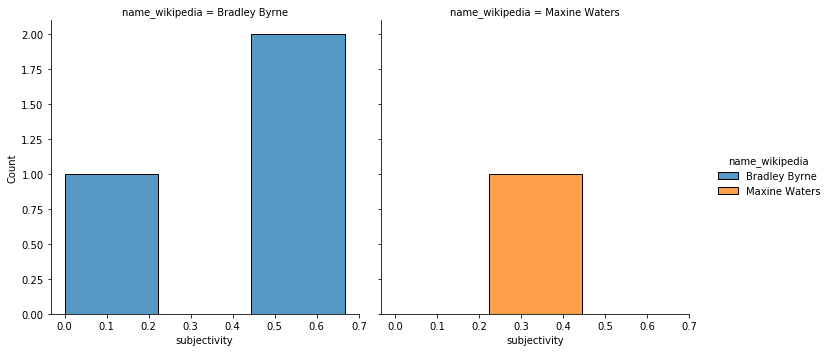

In [37]:
#Plot sentiment subjectivity for conservative & liberal legislators
sns.displot(sentiment_1, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

In [38]:
#creating Dems (and checking dataset)
dem_tweets = congress_tweets[congress_tweets.party == 'Democrat']
dem_tweets.head(10)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
548996,1.082280e+18,RepSeanMaloney,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",suppose trump seriously literally steel barrie...
883815,1.299790e+18,RepDonBeyer,2020-08-29T15:08:50-04:00,RT @JECDems Racial disparities are at the hear...,Don Beyer,Rep,3-Jan-15,6/20/1950,M,VA,8,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522",jecdems racial disparity heart black americans...
895281,1.125470e+18,PattyMurray,2019-05-06T14:25:00-04:00,Grateful for our servicemembers in Washington ...,Patty Murray,Sen,3-Jan-17,10/11/1950,F,WA,Senate,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670",grateful servicemember washington state amp wo...
585652,1.242130e+18,RepSeanMaloney,2020-03-23T12:45:45-04:00,We can't sit around and wait for this virus to...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",sit wait virus spike need prepare surge minute...
58052,1.088520e+18,NormaJTorres,2019-01-24T14:15:55-05:00,Did I mention @JoeBiden is on our flight? I’m ...,Norma Torres,Rep,3-Jan-15,4/4/1965,F,CA,35,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",mention joebiden flight thrilled middle seat r...
923372,1.193180e+18,Sen_JoeManchin,2019-11-09T09:43:00-05:00,#ICYMI: Watch my announcement of the Bipartisa...,Joe Manchin,Sen,15-Nov-10,8/24/1947,M,WV,Senate,Democrat,"489,371","188,794","238,269","417,655",icymi watch announcement bipartisan american m...
514891,1.187370e+18,BillPascrell,2019-10-24T10:00:32-04:00,This is extraordinary. The NY state bar has ca...,Bill Pascrell,Rep,3-Jan-13,1/25/1937,M,NJ,9,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568",extraordinary ny state bar ag barr recuse ukra...
577238,1.208820e+18,SenSchumer,2019-12-22T13:32:57-05:00,If there is nothing wrong with withholding the...,Chuck Schumer,Sen,3-Jan-17,11/23/1950,M,NY,Senate,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",wrong withhold aid michael duffey want know pe...
501693,1.327370e+18,SenatorShaheen,2020-11-13T17:15:57-05:00,.@StateDept – despite efforts to downplay the ...,Jeanne Shaheen,Sen,3-Jan-09,1/28/1947,F,NH,Senate,Democrat,"345,790","348,526","369,561","329,918",statedept – despite effort downplay impact – a...
675169,1.086360e+18,CongBoyle,2019-01-18T15:28:06-05:00,RT @WaysMeansCmte January 2019: Mnuchin refuse...,Brendan Boyle,Rep,3-Jan-15,2/6/1977,M,PA,2,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434",waysmeanscmte january mnuchin refuse appear co...


In [39]:
#creating Republicans (and checking dataset)
repub_tweets = congress_tweets[congress_tweets.party == 'Republican']
repub_tweets.head(10)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
36257,1.276160e+18,RepDavid,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654",adopt olivia spend great time learn arizona fo...
652347,1.322270e+18,RepSteveChabot,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",thank lieutenant mike tarr fire chief ott hube...
267614,1.103730e+18,SenatorRisch,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911",remark amfreesyria share concern devastation w...
344386,1.097350e+18,RepThomasMassie,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190",jeroneanderson montcolp lelandshow realdonaldt...
834593,1.317530e+18,JohnCornyn,2020-10-17T14:35:28-04:00,"RT @CBPMarkMorgan Early this morning, USBP age...",John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",cbpmarkmorgan early morning usbp agent locate ...
460421,1.295440e+18,SenatorWicker,2020-08-17T15:19:36-04:00,Americans have been deeply disturbed by the ch...,Roger Wicker,Sen,31-Dec-07,7/5/1951,M,MS,Senate,Republican,"700,714","485,131","562,949","710,746",americans deeply disturb chaos unfold lately c...
338915,1.129050e+18,SenPatRoberts,2019-05-16T11:55:01-04:00,RT @SenateAgGOP #TBT to 1992 when #Kansas #FFA...,Pat Roberts,Sen,3-Jan-97,4/20/1936,M,KS,Senate,Republican,"671,018","427,005","440,726","692,634",senateaggop tbt kansas ffa visit washington
617622,1.254890e+18,RepRichHudson,2020-04-27T17:49:25-04:00,RT @CLTMotorSpdwy Happy birthday @austindillon...,Richard Hudson,Rep,3-Jan-13,11/4/1971,M,NC,8,Republican,"2,362,631","2,189,316","2,178,391","2,270,395",cltmotorspdwy happy birthday austindillon hope...
844815,1.186700e+18,SenMikeLee,2019-10-22T13:39:45-04:00,Great meeting with @alexisohanian and @PaidLea...,Mike Lee,Sen,3-Jan-19,6/4/1971,M,UT,Senate,Republican,"515,231","310,676","251,813","740,600",great meeting alexisohanian paidleaveus today ...
926478,1.260670e+18,SenCapito,2020-05-13T16:35:34-04:00,We know the bottom line to deploying #broadban...,Shelley Moore Capito,Sen,3-Jan-15,11/26/1953,F,WV,Senate,Republican,"489,371","188,794","238,269","417,655",know line deploy broadband time money state li...


In [40]:
#Get polarity & subjectivity for Dem & Republican tweets
dem_tweets['polarity'] = dem_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
dem_tweets['subjectivity'] = dem_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

repub_tweets['polarity'] = repub_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
repub_tweets['subjectivity'] = repub_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#Combine data frames
party_combined = [dem_tweets, repub_tweets]
sentiment_2 = pd.concat(party_combined)

/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

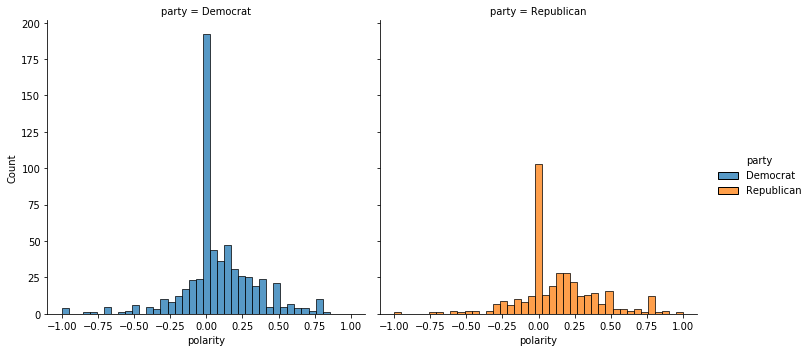

In [41]:
#Plot sentiment polarity for Dems vs. Republicans
sns.displot(sentiment_2, x="polarity", hue = "party", col = "party")
plt.show()

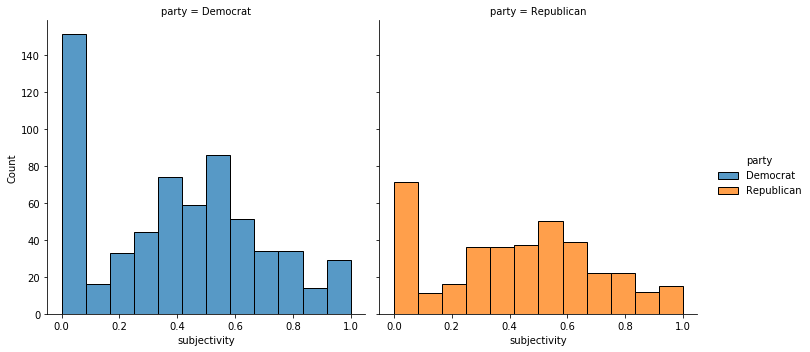

In [42]:
#Plot sentiment subjectivity for Dems vs. Republicans
sns.displot(sentiment_2, x="subjectivity", hue = "party", col = "party")
plt.show()

In [43]:
#Polarity & subjectivity for Senate tweets
sen_tweets = congress_tweets[congress_tweets.position == 'Sen']
sen_tweets['polarity'] = sen_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
sen_tweets['subjectivity'] = sen_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#Polarity & subjectivity for House tweets
rep_tweets = congress_tweets[congress_tweets.position == 'Rep']
rep_tweets['polarity'] = rep_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
rep_tweets['subjectivity'] = rep_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#Combine data frames
congress_combined = [sen_tweets, rep_tweets]
sentiment_3 = pd.concat(congress_combined)

/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jasminesanders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is t

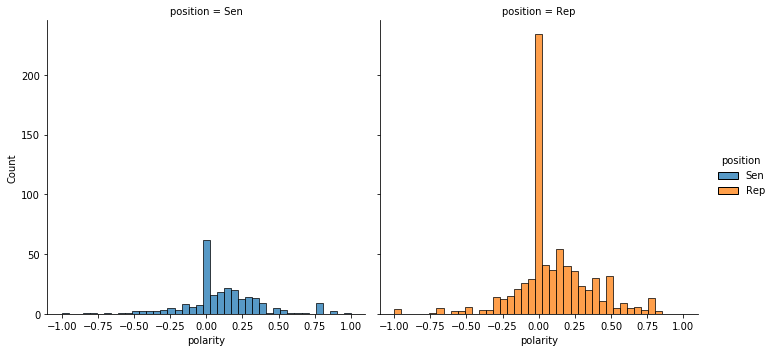

In [44]:
#Plot sentiment polarity for Senate vs. House
sns.displot(sentiment_3, x="polarity", hue = "position", col = "position")
plt.show()

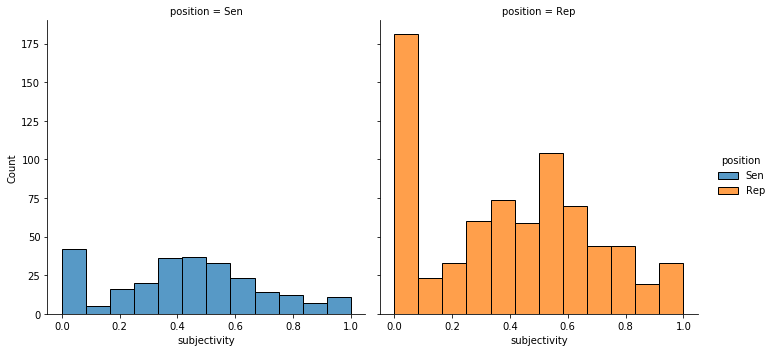

In [45]:
#Plot sentiment subjectivity for Senate vs. House
sns.displot(sentiment_3, x="subjectivity", hue = "position", col = "position")
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [46]:
# Engineered Features
word_count = pd.DataFrame([len(str(x).split()) for x in congress_tweets['tokens']], columns = ['word_count'])
word_count

,word_count
0,42
1,10
2,10
3,24
4,7
...,...
995,11
996,26
997,32
998,19


In [47]:
character_count = pd.DataFrame([len(x) for x in congress_tweets['text']], columns = ['character_count'])
character_count

,character_count
0,755
1,110
2,156
3,325
4,102
...,...
995,321
996,350
997,496
998,384


In [48]:
#already generated from EDA

topic_dist_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.027533,0.027351,0.027400,0.027357,0.862814,0.027544
1,0.040522,0.040552,0.040515,0.040551,0.040552,0.797308
2,0.040671,0.040680,0.795887,0.040978,0.040763,0.041021
3,0.029056,0.029134,0.029082,0.854666,0.029040,0.029022
4,0.046526,0.046491,0.046515,0.767418,0.046525,0.046525
...,...,...,...,...,...,...
995,0.039320,0.039426,0.039332,0.039351,0.803235,0.039335
996,0.027807,0.028113,0.027724,0.027872,0.860669,0.027815
997,0.027136,0.027211,0.027168,0.027134,0.027300,0.864051
998,0.031595,0.842059,0.031554,0.031561,0.031573,0.031659


In [49]:
# review from sentiment analysis goes here
sentiment_combined = [sentiment_1, sentiment_2, sentiment_3]
sentiment_score = pd.concat(sentiment_combined).reset_index(drop=True)
sentiment_score

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity,subjectivity
0,1.203510e+18,RepByrne,2019-12-07T21:59:32-05:00,"On Dec. 7, 1941, 2,000+ Americans were killed ...",Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",dec americans kill pearl harbor throw war clai...,0.284848,0.616667
1,1.126580e+18,RepByrne,2019-05-09T16:04:32-04:00,It was a pleasure talking with representatives...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",pleasure talk representative tennesseetombigbe...,0.000000,0.000000
2,1.192560e+18,RepByrne,2019-11-07T17:09:47-05:00,Amb. Volker said there was no linkage between ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",amb volker linkage wh meeting amp investigatio...,-0.700000,0.666667
3,1.323620e+18,RepMaxineWaters,2020-11-03T08:19:06-05:00,"Today, Tuesday Nov 3rd is a very special day i...",Maxine Waters,Rep,3-Jan-91,8/15/1938,F,CA,43,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",today tuesday nov rd special day country impor...,0.208571,0.434762
4,1.082280e+18,RepSeanMaloney,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",suppose trump seriously literally steel barrie...,-0.333333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,1.179560e+18,RepTimBurchett,2019-10-02T20:54:26-04:00,Thank you @honorair for organizing these meani...,Tim Burchett,Rep,3-Jan-19,8/25/1964,M,TN,2,Republican,"1,522,925","870,695","960,709","1,462,330",thank honorair organize meaningful trip vetera...,0.250000,0.250000
1992,1.311310e+18,RepMcCaul,2020-09-30T10:10:58-04:00,RT @HouseGOP 🚨 NEW: @China_TaskForce releases ...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",housegop 🚨 new chinataskforce release china ta...,0.090909,0.318182
1993,1.293930e+18,RepRickCrawford,2020-08-13T11:32:38-04:00,The President has worked dilligenty since his ...,Rick Crawford,Rep,3-Jan-11,1/22/1966,M,AR,1,Republican,"684,872","380,494","394,409","647,744",president work dilligenty election find peace ...,-0.283333,0.900000
1994,1.083900e+18,JoaquinCastrotx,2019-01-11T20:36:29-05:00,"RT @BobMooreNews ""It's not OK to say that all ...",Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",bobmoorenews ok federal employee support shutd...,0.000000,0.700000


In [50]:
# combine into dataframe
engineered_features = topic_dist_df.join(character_count).join(word_count).join(sentiment_score)
engineered_features

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,character_count,word_count,tweet_id,screen_name,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity,subjectivity
0,0.027533,0.027351,0.027400,0.027357,0.862814,0.027544,755,42,1.203510e+18,RepByrne,...,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",dec americans kill pearl harbor throw war clai...,0.284848,0.616667
1,0.040522,0.040552,0.040515,0.040551,0.040552,0.797308,110,10,1.126580e+18,RepByrne,...,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",pleasure talk representative tennesseetombigbe...,0.000000,0.000000
2,0.040671,0.040680,0.795887,0.040978,0.040763,0.041021,156,10,1.192560e+18,RepByrne,...,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",amb volker linkage wh meeting amp investigatio...,-0.700000,0.666667
3,0.029056,0.029134,0.029082,0.854666,0.029040,0.029022,325,24,1.323620e+18,RepMaxineWaters,...,CA,43,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",today tuesday nov rd special day country impor...,0.208571,0.434762
4,0.046526,0.046491,0.046515,0.767418,0.046525,0.046525,102,7,1.082280e+18,RepSeanMaloney,...,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",suppose trump seriously literally steel barrie...,-0.333333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.039320,0.039426,0.039332,0.039351,0.803235,0.039335,321,11,1.103060e+18,RepMichaelWaltz,...,FL,6,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",combat veteran member nationalguard grateful p...,-0.007143,0.114286
996,0.027807,0.028113,0.027724,0.027872,0.860669,0.027815,350,26,1.103730e+18,SenatorRisch,...,ID,Senate,Republican,"409,055","189,765","212,787","420,911",remark amfreesyria share concern devastation w...,-0.437500,0.500000
997,0.027136,0.027211,0.027168,0.027134,0.027300,0.864051,496,32,1.317530e+18,JohnCornyn,...,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",cbpmarkmorgan early morning usbp agent locate ...,-0.150000,0.450000
998,0.031595,0.842059,0.031554,0.031561,0.031573,0.031659,384,19,1.125470e+18,PattyMurray,...,WA,Senate,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670",grateful servicemember washington state amp wo...,0.000000,0.000000


### Bag-of-words or Tf-idf

In [51]:
# Frequency Based featurization
tfidf_matrix

<1000x5833 sparse matrix of type '<class 'numpy.float64'>'
	with 18683 stored elements in Compressed Sparse Row format>

### Word Embedding

In [52]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [53]:
import numpy as np
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model.wv.__getitem__(doc), axis=0)

In [54]:
# embedding based featurization
model = gensim.models.Word2Vec(congress_tweets['tokens'], size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=5, batch_words=10000)

In [55]:
model.wv.vocab

{'a': <gensim.models.keyedvectors.Vocab at 0x1a28b0dd90>,
 'd': <gensim.models.keyedvectors.Vocab at 0x1b7b37ba50>,
 'o': <gensim.models.keyedvectors.Vocab at 0x1b7b37bb90>,
 'p': <gensim.models.keyedvectors.Vocab at 0x1b7b37bc90>,
 't': <gensim.models.keyedvectors.Vocab at 0x1b7b37bd10>,
 ' ': <gensim.models.keyedvectors.Vocab at 0x1b7b37bd90>,
 'l': <gensim.models.keyedvectors.Vocab at 0x1b7b37bdd0>,
 'i': <gensim.models.keyedvectors.Vocab at 0x1b7b37be10>,
 'v': <gensim.models.keyedvectors.Vocab at 0x1b7b37bcd0>,
 's': <gensim.models.keyedvectors.Vocab at 0x1b7b37bd50>,
 'e': <gensim.models.keyedvectors.Vocab at 0x1b7b37be50>,
 'n': <gensim.models.keyedvectors.Vocab at 0x1b7b37be90>,
 'g': <gensim.models.keyedvectors.Vocab at 0x1b7b37bed0>,
 'r': <gensim.models.keyedvectors.Vocab at 0x1b7b37bf10>,
 'm': <gensim.models.keyedvectors.Vocab at 0x1b7b37bf50>,
 'z': <gensim.models.keyedvectors.Vocab at 0x1b7b37bf90>,
 'f': <gensim.models.keyedvectors.Vocab at 0x1b7b37bfd0>,
 'c': <gensim.

In [56]:
doc = [word for word in congress_tweets.reset_index()['tokens'][0] if word in model.wv.vocab]

In [57]:
document_vector(model, congress_tweets.reset_index()['tokens'][0])

array([-0.17663918, -0.06204673, -0.02360658, -0.19523925,  0.00431685,
        0.04086073, -0.0139848 ,  0.15591326, -0.30653438, -0.01666587,
       -0.00556261,  0.16646497, -0.0937001 ,  0.15882297,  0.20585747,
       -0.00448353, -0.0058551 , -0.21271376,  0.0625131 , -0.02759368,
       -0.10985637, -0.05227173,  0.22623375, -0.12074358, -0.05919747,
        0.04650492,  0.11539798, -0.11468533,  0.11460062, -0.04820998,
        0.13146019,  0.09429498, -0.23338257,  0.16295107, -0.11840289,
        0.11246984,  0.08415134,  0.09323151,  0.17120205,  0.18651107,
       -0.1049552 ,  0.01538154, -0.10019297,  0.08569252,  0.02591318,
        0.01896975, -0.2395858 , -0.06295425,  0.20168644,  0.11910792,
        0.17602839,  0.02938053, -0.02729804,  0.07767075, -0.14797567,
        0.04877675, -0.12029361,  0.08872693,  0.11520015,  0.01453092,
        0.09900775,  0.18834072,  0.04298557,  0.1137491 ,  0.15199493,
        0.14771473, -0.07262301,  0.04107681,  0.00459995,  0.00

In [58]:
test = [document_vector(model, x) for x in congress_tweets.reset_index()['tokens']]

ValueError: need at least one array to concatenate

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [59]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Engineered Features (trying this without to resolve error below)
#dataframes = [engineered_features]

#featurization_technique = ['Engineered Text Features']

#lb_style = LabelBinarizer()
#y = congress_tweets['party'] = lb_style.fit_transform(congress_tweets['party'])

In [60]:
engineered_features_df = pd.DataFrame(engineered_features)

In [61]:
#for dataframe, featurization in zip(dataframes, featurization_technique): (trying to resolve error)
y = congress_tweets['party']

X_train, X_test, y_train, y_test = train_test_split(engineered_features_df, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
df_cm.index = ["Republican", "Democrat"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Google Document Averaged Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

ValueError: could not convert string to float: 'irs operation continue reopen country center staff return amp additional staff available tollfree line check status direct payment'

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])


## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**